In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [21]:
df = pd.read_csv('../data/bodyPerformance.csv')
print(df.head())
print(df.columns)


    age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C  
3       41.4                     15.2            53.0          219.0     B  
4       43.5                     27.1            45.0          217.0     B  
Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gr

In [22]:

df['fitness'] = df['class'].map({
    'A': 1,  # Fit
    'B': 1,  # Fit
    'C': 0,  # Unfit
    'D': 0   # Unfit
})


print(df[['class', 'fitness']].head(10))
print(df['fitness'].value_counts())
print(df['fitness'].value_counts(normalize=True))


  class  fitness
0     C        0
1     A        1
2     C        0
3     B        1
4     B        1
5     B        1
6     D        0
7     B        1
8     C        0
9     B        1
fitness
0    6698
1    6695
Name: count, dtype: int64
fitness
0    0.500112
1    0.499888
Name: proportion, dtype: float64


In [23]:

df['BMI'] = df['weight_kg'] / (df['height_cm']/100) ** 2
df['bodyFatRatio'] = df['body fat_%'] / df['BMI']
df['strength_ratio'] = df['gripForce'] / df['weight_kg']
df['jump_ratio'] = df['broad jump_cm'] / df['height_cm']
df['situp_ratio'] = df['sit-ups counts'] / df['age']
df['flexibility_ratio'] = df['sit and bend forward_cm'] / df['height_cm']

df.head()


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,fitness,BMI,bodyFatRatio,strength_ratio,jump_ratio,situp_ratio,flexibility_ratio
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,0,25.344179,0.840430,0.729665,1.259431,2.222222,0.106790
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,1,20.495868,0.766008,0.652330,1.387879,2.120000,0.098788
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,0,24.181428,0.831216,0.574359,1.007795,1.580645,0.066815
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,1,23.349562,0.788023,0.582278,1.255014,1.656250,0.087106
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,1,22.412439,0.762969,0.642541,1.248562,1.607143,0.155926


In [24]:

drop_cols = [
   
    'broad jump_cm',
    'sit-ups counts',
    'sit and bend forward_cm'
]

df = df.drop(columns=drop_cols)


In [25]:

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])


df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')


df = df.dropna().reset_index(drop=True)
cols_to_check = df.select_dtypes(include=['float64', 'int64']).columns
cols_to_check = cols_to_check.drop('gender', errors='ignore').drop('fitness', errors='ignore')
df = df[(df[cols_to_check] > 0).all(axis=1)].reset_index(drop=True)

df.head(10)


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,class,fitness,BMI,bodyFatRatio,strength_ratio,jump_ratio,situp_ratio,flexibility_ratio
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,C,0,25.344179,0.840430,0.729665,1.259431,2.222222,0.106790
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,A,1,20.495868,0.766008,0.652330,1.387879,2.120000,0.098788
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,C,0,24.181428,0.831216,0.574359,1.007795,1.580645,0.066815
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,B,1,23.349562,0.788023,0.582278,1.255014,1.656250,0.087106
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,B,1,22.412439,0.762969,0.642541,1.248562,1.607143,0.155926
5,36.0,0,165.4,55.40,22.0,64.0,119.0,23.8,B,1,20.250640,1.086385,0.429603,0.925030,0.750000,0.126965
6,42.0,0,164.5,63.70,32.2,72.0,135.0,22.7,D,0,23.540063,1.367881,0.356358,0.887538,0.428571,0.004863
7,33.0,1,174.9,77.20,36.9,84.0,137.0,45.9,B,1,25.236997,1.462139,0.594560,1.337907,1.272727,0.070326
8,54.0,1,166.8,67.50,27.6,85.0,165.0,40.4,C,0,24.261167,1.137620,0.598519,0.887290,0.629630,0.111511
9,28.0,1,185.0,84.60,14.4,81.0,156.0,57.9,B,1,24.718773,0.582553,0.684397,1.151351,1.964286,0.065405


In [ ]:
X = df.drop(columns=['class', 'fitness'], errors='ignore')  
y = df['fitness']

print(X.shape, y.shape)


(12621, 14) (12621,)


In [27]:
no_scale_cols = ['gender']
scale_cols = [col for col in X.columns if col not in no_scale_cols]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

X_train_scaled.head()


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,BMI,bodyFatRatio,strength_ratio,jump_ratio,situp_ratio,flexibility_ratio
7692,-0.710581,1,1.059155,1.477636,-0.191740,1.509090,1.548962,0.971899,1.163085,-0.588702,0.118186,-0.540263,0.948576,1.480626
8962,0.175138,0,-1.565230,-1.434788,0.355951,0.018628,0.049008,-0.635202,-0.935503,0.797423,0.485204,-0.525027,-0.749802,0.930900
6032,1.134666,1,-0.091260,0.017154,0.426167,1.322782,2.503478,0.182446,0.145393,0.343362,0.279039,0.300185,-0.785937,-0.864946
8599,1.429905,1,0.771551,0.948105,-0.388347,1.229629,1.412602,0.689951,0.714859,-0.636311,0.173597,0.399103,-0.561380,0.500934
475,-1.079630,0,-1.876801,-1.895993,-0.304087,-0.633449,-1.587305,-1.152106,-1.492716,0.324943,0.039524,0.292211,1.076693,1.118940


In [28]:
lr_base = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'
)

param_grid = {'C': [0.01, 0.1, 1, 3, 5, 10]}

grid_lr = GridSearchCV(
    lr_base,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_lr.fit(X_train_scaled, y_train)

lr_model = grid_lr.best_estimator_
lr_model


LogisticRegression(C=3, class_weight='balanced', max_iter=1000)

In [29]:
param_grid_knn = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)
knn_model = grid_knn.best_estimator_
knn_model


KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [ ]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier(
    n_estimators=300,    
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  
)


xgb_model.fit(X_train_scaled, y_train)


c:\Users\G5 840\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:37:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_base = RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

param_grid = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.6, 0.8],
    'bootstrap': [True]
}

grid_rf = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

grid_rf.fit(X_train_scaled, y_train)

rf_model = grid_rf.best_estimator_
print("Best Random Forest Hyperparameters:\n", rf_model)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Hyperparameters:
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.8, min_samples_leaf=2, n_estimators=600,
                       n_jobs=-1, random_state=42)


In [ ]:


def evaluate(model, X_test_scaled, y_test):
    preds = model.predict(X_test_scaled)
    probs = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    
    accuracy = accuracy_score(y_test, preds)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0   
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0   

    print("Accuracy:", round(accuracy, 3))
    print("Sensitivity (Recall – Fit):", round(sensitivity, 3))
    print("Specificity (Recall – Unfit):", round(specificity, 3))

    if probs is not None:
        print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))

    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)


In [33]:
print("Logistic Regression")
evaluate(lr_model, X_test_scaled, y_test)



Logistic Regression
Accuracy: 0.797
Sensitivity (Recall – Fit): 0.809
Specificity (Recall – Unfit): 0.783
ROC AUC: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1186
           1       0.81      0.81      0.81      1339

    accuracy                           0.80      2525
   macro avg       0.80      0.80      0.80      2525
weighted avg       0.80      0.80      0.80      2525

Confusion Matrix:
[[ 929  257]
 [ 256 1083]]
--------------------------------------------------


In [34]:
print("KNN")
evaluate(knn_model, X_test_scaled, y_test)




KNN
Accuracy: 0.791
Sensitivity (Recall – Fit): 0.889
Specificity (Recall – Unfit): 0.68
ROC AUC: 0.871

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1186
           1       0.76      0.89      0.82      1339

    accuracy                           0.79      2525
   macro avg       0.80      0.78      0.79      2525
weighted avg       0.80      0.79      0.79      2525

Confusion Matrix:
[[ 807  379]
 [ 149 1190]]
--------------------------------------------------


In [35]:
print("Random Forest")
evaluate(rf_model, X_test_scaled, y_test)



Random Forest
Accuracy: 0.841
Sensitivity (Recall – Fit): 0.889
Specificity (Recall – Unfit): 0.788
ROC AUC: 0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1186
           1       0.83      0.89      0.86      1339

    accuracy                           0.84      2525
   macro avg       0.84      0.84      0.84      2525
weighted avg       0.84      0.84      0.84      2525

Confusion Matrix:
[[ 934  252]
 [ 149 1190]]
--------------------------------------------------


In [36]:
print("X Gradient Boosting")
evaluate(xgb_model, X_test_scaled, y_test)

X Gradient Boosting
Accuracy: 0.865
Sensitivity (Recall – Fit): 0.916
Specificity (Recall – Unfit): 0.808
ROC AUC: 0.934

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1186
           1       0.84      0.92      0.88      1339

    accuracy                           0.87      2525
   macro avg       0.87      0.86      0.86      2525
weighted avg       0.87      0.87      0.86      2525

Confusion Matrix:
[[ 958  228]
 [ 112 1227]]
--------------------------------------------------


In [37]:
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

print("Feature Importance Ranking:\n")
for i in sorted_idx:
    print(f"{feature_names[i]} : {importances[i]:.4f}")


Feature Importance Ranking:

flexibility_ratio : 0.3325
strength_ratio : 0.1426
situp_ratio : 0.0989
age : 0.0853
jump_ratio : 0.0680
bodyFatRatio : 0.0413
height_cm : 0.0353
body fat_% : 0.0342
weight_kg : 0.0331
BMI : 0.0327
gripForce : 0.0312
systolic : 0.0271
diastolic : 0.0247
gender : 0.0131


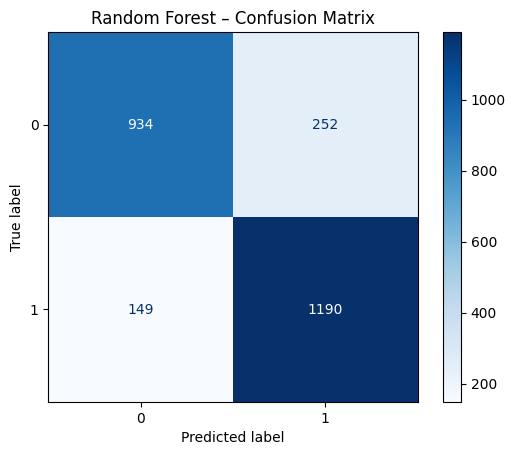

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test_scaled,
    y_test,
    cmap='Blues'
)

plt.title("Random Forest – Confusion Matrix")
plt.show()


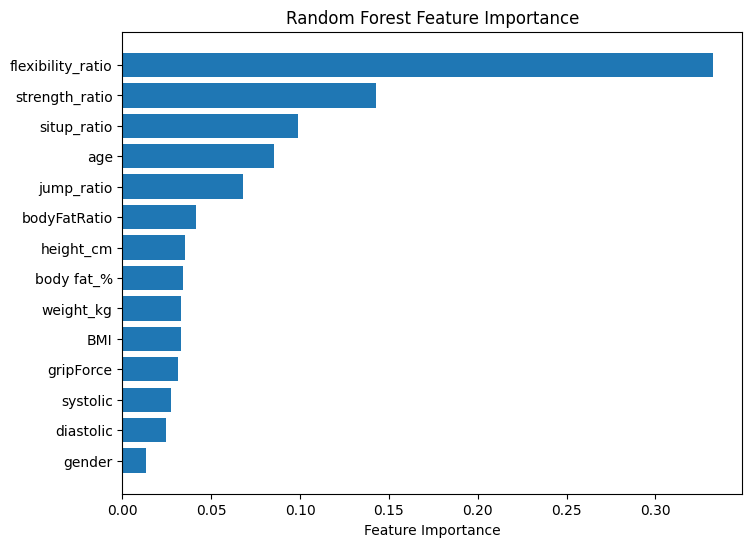

In [39]:
importances = rf_model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


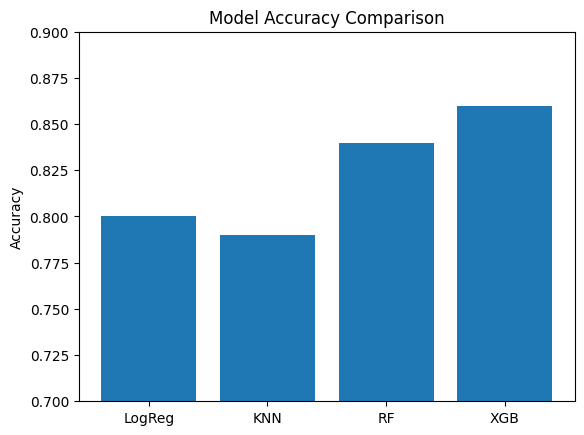

In [40]:
models = ['LogReg', 'KNN', 'RF', 'XGB']
accuracies = [0.80, 0.79, 0.84, 0.86]

plt.bar(models, accuracies)
plt.ylim(0.7, 0.9)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


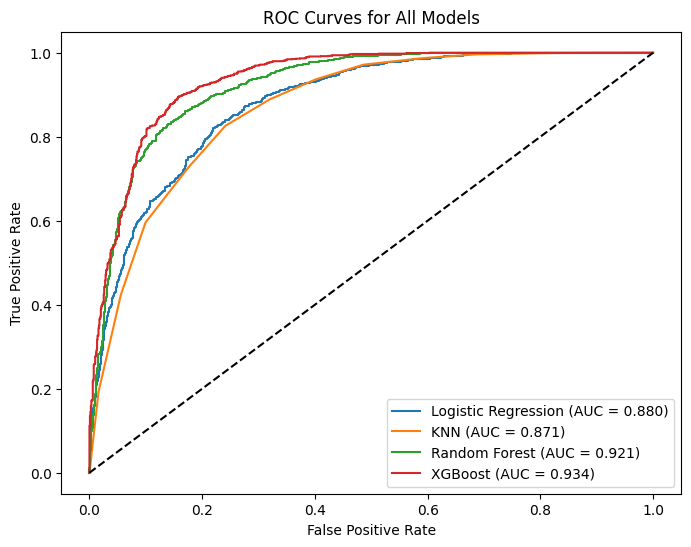

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

models = {
    'Logistic Regression': lr_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_scaled)[:,1]
    else:
        probs = model.predict(X_test_scaled)  

    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
